In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [2]:
def read_csv_files():
    base_path = '../data/stock/'
    all_files = glob.glob(os.path.join(base_path, "*.csv"))
    
    df_list = []
    
    for file_path in all_files:
        ticker = os.path.splitext(os.path.basename(file_path))[0]
        df = pd.read_csv(file_path, parse_dates=['date'])

        # 최소 1년치 데이터 보유 시에만 추가
        if len(df) >= 252:  
            df['ticker'] = ticker   # 티커 컬럼 추가
            df.drop([
                'adjClose', 'adjHigh', 'adjLow', 'adjOpen',
                'adjVolume', 'divCash', 'splitFactor'
            ], axis=1, inplace=True)
            df_list.append(df)
    return df_list

In [3]:
def find_shortest_period(df_list):
    min_dates = []
    max_dates = []

    for df in df_list:
        min_dates.append(df['date'].min())
        max_dates.append(df['date'].max())

    # 모든 종목이 공통으로 갖는 기간
    start_date = max(min_dates)
    end_date = min(max_dates)
    return start_date, end_date

In [4]:
def same_period(df_list, start_date, end_date):
    trimmed_list = []

    for df in df_list:
        mask = (df['date'] >= start_date) & (df['date'] <= end_date)
        trimmed_df = df.loc[mask].copy()
        trimmed_list.append(trimmed_df)
    return trimmed_list

In [5]:
def calculate_rsi(series, period=14):
    delta = series.diff()  # 하루 전 대비 가격 변화량
    # 상승폭 평균(오른 날은 양수, 내린 날은 0으로 처리)
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    # 하락폭 평균(내린 날은 양수, 오른 날은 0으로 처리)
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss  # 상대 강도
    rsi = 100 - (100 / (1 + rs))  # RSI 공식
    return rsi


def calculate_mdd(series):
    roll_max = series.cummax()  # 누적 최고가 시계열
    drawdown = (series - roll_max) / roll_max
    mdd = drawdown.min()
    return mdd


def calc_1y_features(df):
    df_1y = df.tail(252)
    
    ma_1y = df_1y['close'].mean()
    ret_1y = (df_1y['close'].iloc[-1] / df_1y['close'].iloc[0]) - 1
    # 최근 1년 변동성 (로그수익률 표준편차 × sqrt(252)로 연환산)
    logret = np.log(df_1y['close'] / df_1y['close'].shift(1)).dropna()
    vola_1y = logret.std() * np.sqrt(252)  # 연율화[2][3][5]
    return ma_1y, ret_1y, vola_1y


def extract_features(df):
    ticker = df['ticker'].unique()[0]
    ma60 = df['close'].rolling(window=60).mean().iloc[-1]
    ret = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1
    vola = df['close'].pct_change().rolling(window=30).std().mean()
    rsi = calculate_rsi(df['close'], 14).iloc[-1]
    mdd = calculate_mdd(df['close'])
    avg_vol = df['volume'].mean()

    ma_1y, ret_1y, vola_1y = calc_1y_features(df)
    
    return [ticker, ma60, ma_1y, ret, ret_1y, vola, vola_1y, rsi, mdd, avg_vol]

In [6]:
def make_feature_df(df_list):
    feature_names = [
        'Ticker', 'MA_60', 'MA_1Y', 'Total_Return', 'Return_1Y', 
        'Vol_30', 'Vol_1Y', 'RSI_14', 'MDD', 'Avg_Volume'
        ]
    features_list = []

    for df in df_list:
        feats = extract_features(df)
        features_list.append(feats)

    features_df = pd.DataFrame(features_list, columns=feature_names)
    features_df.set_index('Ticker', inplace=True)
    return features_df

In [7]:
def k_means():
    df_list = read_csv_files()
    start_date, end_date = find_shortest_period(df_list)
    trimmed_list = same_period(df_list, start_date, end_date)
    df = make_feature_df(trimmed_list)

    df = df.dropna()    # 결측치 제거

    # 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    df.loc[:, 'Cluster'] = clusters
    print(df.sort_values(by='Cluster'))
    
    # 2차원 시각화
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
    plt.title('K-Means Clustering of Stocks (PCA Visualization)')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    # 클러스터링 평가 지표
    print(silhouette_score(X_scaled, clusters)) # 실루엣 계수
    print(davies_bouldin_score(X_scaled, clusters)) # Davies-Bouldin Index
    print(calinski_harabasz_score(X_scaled, clusters))  # Calinski-Harabasz Index

             MA_60       MA_1Y  Total_Return  Return_1Y    Vol_30    Vol_1Y  \
Ticker                                                                        
BILS     99.312750   99.282723     -0.000604   0.001413  0.000839  0.013248   
CDL      66.197335   65.582879      0.070437   0.049650  0.008158  0.145591   
CDEI     67.941302   69.280365      0.095506   0.058132  0.010714  0.198268   
CDC      63.445815   62.848230      0.067412   0.047241  0.008166  0.144904   
IAI     141.485667  134.898107      0.304837   0.273144  0.013679  0.245378   
...            ...         ...           ...        ...       ...       ...   
CLOU     21.864583   21.607083      0.093472   0.113854  0.015772  0.278563   
CLOD     29.692033   29.000959      0.245883   0.200655  0.015381  0.260390   
CLIX     46.529860   45.372268      0.153923   0.084388  0.013001  0.217409   
GNOM      8.457287   10.127618     -0.241304  -0.272917  0.018978  0.323888   
IEDI     51.728397   51.439100      0.121401   0.099

c:\Users\kdh80\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


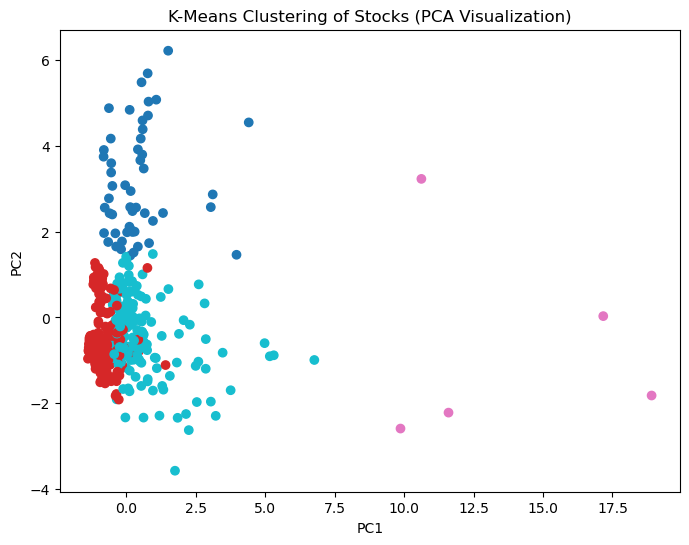

0.268022658690581
1.1130357266204796
159.35356839081868


In [8]:
k_means()